# Birdsong classification

Copyright 2020 BioDatarium (Authors: Ewald Enzinger, Dalila Rendon)

This project comes from the birdcall identification challenge (https://www.kaggle.com/c/birdsong-recognition). 

The train data consists of short recordings of individual bird calls. First we look at distributions of audio durations, and number of training examples per class (bird code). We discovered that there are audio files that last from 0.39 seconds to over 4 minutes, and on the latter there were at least three different bird calls as well as other sources of noise, with one target bird label and multiple secondary bird labels. The problem is that for someone who is not an ornithologist, there is no way of knowing to which extra calls do the secondary labels belong to. The second issue that that the training data is unbalanced- there are only a few calls from some birds, and many more calls from other birds. A priori, it's unclear how to deal with those long poorly labeled audios - ideally, we would have a single short audio clip with one call and one single label to train a model. 

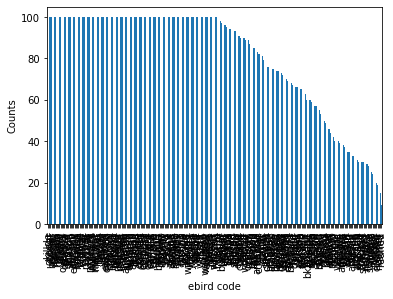

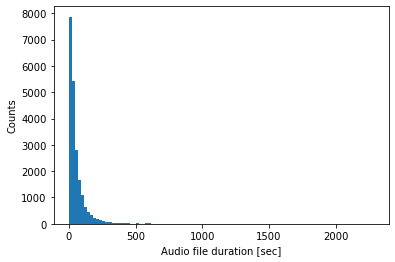

,rating,playback_used,ebird_code,channels,date,pitch,duration,filename,speed,species,...,xc_id,url,country,author,primary_label,longitude,length,time,recordist,license
0,3.5,no,aldfly,1 (mono),2013-05-25,Not specified,25,XC134874.mp3,Not specified,Alder Flycatcher,...,134874,https://www.xeno-canto.org/134874,United States,Jonathon Jongsma,Empidonax alnorum_Alder Flycatcher,-92.962,Not specified,8:00,Jonathon Jongsma,Creative Commons Attribution-ShareAlike 3.0
1,4.0,no,aldfly,2 (stereo),2013-05-27,both,36,XC135454.mp3,both,Alder Flycatcher,...,135454,https://www.xeno-canto.org/135454,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...
2,4.0,no,aldfly,2 (stereo),2013-05-27,both,39,XC135455.mp3,both,Alder Flycatcher,...,135455,https://www.xeno-canto.org/135455,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...
3,3.5,no,aldfly,2 (stereo),2013-05-27,both,33,XC135456.mp3,both,Alder Flycatcher,...,135456,https://www.xeno-canto.org/135456,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...
4,4.0,no,aldfly,2 (stereo),2013-05-27,both,36,XC135457.mp3,level,Alder Flycatcher,...,135457,https://www.xeno-canto.org/135457,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...


In [25]:
#==========================================================================================
# Inspect raw data
#==========================================================================================

%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt

# Look at .csv file structure
raw = pd.read_csv("/mnt/localdata/data/audio/birdsong/train.csv")

# Plot bird type vs counts
plt.figure()
raw_grouped = raw.groupby('ebird_code').duration.count().sort_values(ascending=False).plot.bar()
plt.ylabel('Counts')
plt.xlabel('ebird code')
plt.show()

# Plot histogram of audio file duration
plt.figure()
raw.duration.plot.hist(bins=100)
plt.ylabel('Counts')
plt.xlabel('Audio file duration [sec]')
plt.show()

raw.head()

Our first approach was to divide every audio file into individual chunks lasting at most 5 seconds, and assign the primary target bird label to each 5-second file. Files that were originally less than 5 seconds long remain unaltered. This is not ideal, as it is likely that some secondary background calls will be incorrectly labeled with the primary target label. Other options (not shown here) are to eliminate bird classes with few samples, eliminate audios with multiple calls, or eliminate long audio files. It is unlikely that this particular training dataset will yield an accurate model, but this is one of many options to build a better birdcall recognition model. 

In [ ]:
#==========================================================================================
# DO NOT RUN THIS CELL - Preprocess audio files
#==========================================================================================

# Create subfolders for ebird codes in target directories

!cd /mnt/localdata/data/audio/birdsong/train_audio && for f in *; do mkdir -p ../train_audio_wav/$f ../train_audio_split/$f; done

# Split audio files into at most 5 second chunks

!cd /mnt/localdata/data/audio/birdsong && find train_audio/ -type f -name '*.mp3' -exec mp3splt -t "0.05" -o "../../train_audio_split/@d/@f_@m-@s" -n -x -Q "{}" \;

# Convert 5-second chunks from mp3 to wav, converting to 32000 Hz sampling rate and 16-bit linear PCM encoding (mono)

!cd /mnt/localdata/data/audio/birdsong/train_audio_split && find * -type f -name '*.mp3' -exec sox "{}" -t wav -r 32000 -b 16 -e signed-integer ../train_audio_wav/"{}" channels 1 \;

In [1]:
#==========================================================================================
# Import required packages
#==========================================================================================

import os
from pathlib import Path
import tensorflow as tf
import kymatio.keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.platform import gfile
import numpy as np
import matplotlib

In [2]:
#==========================================================================================
# Load the TensorBoard notebook extension
#==========================================================================================

%load_ext tensorboard

In [37]:
#==========================================================================================
# Set configuration values
#==========================================================================================

#   The configuration values contain settings for training a
#   neural network model, hyperparameters, callback specifications, etc. It also contains the file locations
#   of training and validation sets, and specifies a working directory.

config = {
    "data_dir": "/mnt/localdata/data/audio/birdsong/train_audio_wav",
    "work_dir": "/mnt/localdata/data/audio/birdsong",
    "batch_size": 64,
    "epochs": 50,
    "validation_freq": 1,
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 5,
        "min_delta": 0.0
    },
    "optimizer": "sgd",
    "loss": "sparse_categorical_crossentropy",
    "activation": "relu",
    "output_activation": "softmax",
    "metrics": ["accuracy"],
    "learning_rate_schedule": [ # This makes a dynamic learning rate depending on epoch
        {
            "proportion": 0.33,
            "learning_rate": 0.0001
        },
        {
            "proportion": 0.33,
            "learning_rate": 0.00001
        },
        {
            "proportion": 0.34,
            "learning_rate": 0.000001
        }
    ],
    "checkpoint": True,
    "tensorboard": True
}

# Create working directory if it doesn't exist
os.makedirs(config["work_dir"], exist_ok=True)

In [4]:
#==========================================================================================
# Create parallel lists of file paths and ebird_codes
#==========================================================================================

file_paths = []
ebird_codes = []
# We first define a "search path", which is a pattern of what files to look for.
# In this case, we are looking for WAV audio files within all directories in the
# Folder given by data_dir
search_path = os.path.join(config["data_dir"], '*', '*.wav')
# Now, we are going through each file found with that search pattern, one by one
for wav_path in gfile.Glob(search_path):
    # Here, we get the last part of the path, which is the name of the directory
    # in which the WAV file is. This represents the ebird_code
    ebird_code = Path(wav_path).parent.name
    # Add ebird_code to list
    ebird_codes.append(ebird_code)
    # Add file path to file_paths list
    file_paths.append(wav_path)

In [5]:
#==========================================================================================
# Create numerical targets from ebird_codes
#==========================================================================================

encoder = LabelEncoder()
encoder.fit(ebird_codes)
targets = encoder.transform(ebird_codes)
print(encoder.classes_)

# Save ebird_code to target mapping to a file within the working directory
np.save(Path(config["work_dir"]).joinpath('classes.npy'), encoder.classes_)

['aldfly' 'ameavo' 'amebit' 'amecro' 'amegfi' 'amekes' 'amepip' 'amered'
 'amerob' 'amewig' 'amewoo' 'amtspa' 'annhum' 'astfly' 'baisan' 'baleag'
 'balori' 'banswa' 'barswa' 'bawwar' 'belkin1' 'belspa2' 'bewwre' 'bkbcuc'
 'bkbmag1' 'bkbwar' 'bkcchi' 'bkchum' 'bkhgro' 'bkpwar' 'bktspa' 'blkpho'
 'blugrb1' 'blujay' 'bnhcow' 'boboli' 'bongul' 'brdowl' 'brebla' 'brespa'
 'brncre' 'brnthr' 'brthum' 'brwhaw' 'btbwar' 'btnwar' 'btywar' 'buffle'
 'buggna' 'buhvir' 'bulori' 'bushti' 'buwtea' 'buwwar' 'cacwre' 'calgul'
 'calqua' 'camwar' 'cangoo' 'canwar' 'canwre' 'carwre' 'casfin' 'caster1'
 'casvir' 'cedwax' 'chispa' 'chiswi' 'chswar' 'chukar' 'clanut' 'cliswa'
 'comgol' 'comgra' 'comloo' 'commer' 'comnig' 'comrav' 'comred' 'comter'
 'comyel' 'coohaw' 'coshum' 'cowscj1' 'daejun' 'doccor' 'dowwoo' 'dusfly'
 'eargre' 'easblu' 'easkin' 'easmea' 'easpho' 'eastow' 'eawpew' 'eucdov'
 'eursta' 'evegro' 'fiespa' 'fiscro' 'foxspa' 'gadwal' 'gcrfin' 'gnttow'
 'gnwtea' 'gockin' 'gocspa' 'goleag' 'grbher3

In [6]:
#==========================================================================================
# Split data into training and validation portions (10%)
#==========================================================================================

train_filepaths, validation_filepaths, train_targets, validation_targets = train_test_split(
    file_paths,
    targets,
    test_size=0.1
)

In [7]:
#==========================================================================================
# Create tf.data.Dataset for training and validation data
#==========================================================================================

# Create tf.data.Dataset from training portion
train_dataset = tf.data.Dataset.from_tensor_slices((train_filepaths, train_targets))
# Create tf.data.Dataset from validation portion
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_filepaths, validation_targets))

In [8]:
#==========================================================================================
# Randomly shuffle training dataset (use random seed for replayability)
#==========================================================================================

train_dataset = train_dataset.shuffle(
    buffer_size=train_dataset.cardinality(),
    seed=20150509,
    reshuffle_each_iteration=True
)

print(f"Number of training dataset items: {train_dataset.cardinality()}.")
print(f"Number of validation dataset items: {validation_dataset.cardinality()}.")

Number of training dataset items: 223815.
Number of validation dataset items: 24869.


In [9]:
#==========================================================================================
# Audio loading and processing
#==========================================================================================

def load_audio(filepath, target):
    # Read audio file
    audio = tf.io.read_file(filepath)
    # Decode .wav format. desired_channels turns stereo into mono by picking one channel (not averaging),
    # desired_samples is how many samples
    # extracts from each second of audio file, times the duration of the audio file (5 secs)
    audio, sampling_rate = tf.audio.decode_wav(audio, desired_channels = 1, desired_samples = 32000*5)
    return audio, target

# Apply the transformation / mapping
train_dataset = train_dataset.map(load_audio, num_parallel_calls=tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.map(load_audio, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [10]:
#==========================================================================================
# Create spectrogram
#==========================================================================================

def audio_to_fft(audio, target):
    # Since tf.signal.fft applies FFT on the innermost dimension,
    # we need to squeeze the dimensions and then expand them again
    # after FFT
    audio = tf.squeeze(audio, axis=-1)
    # Compute the (linear frequency) spectrogram of the audio
    # This cuts the audio into overlapping kernels of 30 milliseconds
    # then signal.stft applies applies a fourier tranformation to each
    spec = tf.abs(tf.signal.stft(
        signals=audio, 
        frame_length=int(0.03*32000),
        frame_step=int(0.01*32000),
        fft_length=1024,
        pad_end=True
    ))
    spec = tf.expand_dims(spec, axis=-1)
    #spec = spec[:, : (audio.shape[1] // 2), :]
    return spec, target

train_dataset = train_dataset.map(audio_to_fft, num_parallel_calls=tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.map(audio_to_fft, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [11]:
#==========================================================================================
# Batch datasets and prefetch
#==========================================================================================

# Prepare batches
train_dataset = train_dataset.batch(config["batch_size"])
validation_dataset = validation_dataset.batch(config["batch_size"])
# Prefetch
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [13]:
#==========================================================================================
# Create callbacks for model.fit
#==========================================================================================

#    We want the following callbacks:
#     - EarlyStopping (to stop training early if validation loss does not further improve)
#     - LearningRateSchedule (for adjusting the learning rate)
#     - ModelCheckpoint (for saving checkpoints each epoch)
#     - Tensorboard (for logs)

callbacks = []
# if "early_stopping" in config:
#     # Stop training early when validation accuracy does no longer improve
#     early_stopping_callback = tf.keras.callbacks.EarlyStopping(
#         monitor=config["early_stopping"]["monitor"],
#         min_delta=config["early_stopping"]["min_delta"],
#         patience=config["early_stopping"]["patience"])
#     callbacks.append(early_stopping_callback)

if "learning_rate" in config:
    # Define learning rate schedule
    def learning_rate_schedule(epoch_index: int) -> float:
        epoch_until = 0
        for rule in config["learning_rate"]:
            epoch_until += int(rule['proportion'] * config['epochs'])
            if epoch_index < epoch_until:
                return rule['learning_rate']

    learning_rate_callback = tf.keras.callbacks.LearningRateScheduler(
        learning_rate_schedule, verbose=1)
    callbacks.append(learning_rate_callback)

if "checkpoint" in config:
    # Saving model checkpoints after each epoch
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(config["work_dir"], 'checkpoints', "ckpt-epoch{epoch}-acc={accuracy:.2f}"),
        save_weights_only=True,
        save_freq='epoch',
        monitor='val_accuracy',
        mode='auto',
        save_best_only=True)
    callbacks.append(checkpoint_callback)
if "tensorboard" in config:
    # Writing logs to monitor training in Tensorboard
    checkpoint_tensorboard = tf.keras.callbacks.TensorBoard(
        log_dir=os.path.join(config["work_dir"], 'logs'),
    )
    callbacks.append(checkpoint_tensorboard)

In [38]:
#==========================================================================================
# Build neural network model
#==========================================================================================

# from https://keras.io/examples/audio/speaker_recognition_using_cnn/

def residual_block(x, filters, conv_num=3, activation= config["activation"]):
    # Shortcut
    s = tf.keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = tf.keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = tf.keras.layers.Activation(activation)(x)
    x = tf.keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = tf.keras.layers.Add()([x, s])
    x = tf.keras.layers.Activation(activation)(x)
    return tf.keras.layers.MaxPool1D(pool_size=2, strides=2)(x)


def build_model(input_shape, num_output_units):
    inputs = tf.keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)

    x = tf.keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation= config["activation"])(x)
    x = tf.keras.layers.Dense(128, activation= config["activation"])(x)

    outputs = tf.keras.layers.Dense(num_output_units, activation=config["output_activation"], name="output")(x)

    return tf.keras.models.Model(inputs=inputs, outputs=outputs)


model = build_model(
    input_shape = (500, 1024//2+1), 
    num_output_units = len(encoder.classes_)
)

In [39]:
#==========================================================================================
# Compile the model
#==========================================================================================

# Determine the optimizer, the loss, and the metrics to monitor from the config chunk
model.compile(
    optimizer=config["optimizer"],
    loss=config["loss"],
    metrics=config["metrics"])
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 500, 513)]   0                                            
__________________________________________________________________________________________________
conv1d_19 (Conv1D)              (None, 500, 16)      24640       input[0][0]                      
__________________________________________________________________________________________________
activation_13 (Activation)      (None, 500, 16)      0           conv1d_19[0][0]                  
__________________________________________________________________________________________________
conv1d_20 (Conv1D)              (None, 500, 16)      784         activation_13[0][0]              
_______________________________________________________________________________________

In [40]:
#==========================================================================================
# Train the model
#==========================================================================================

# Determine the batch size, number of epochs, callbacks, and validation frequency from the config
model.fit(train_dataset,
          batch_size=config["batch_size"],
          epochs=config['epochs'],
          callbacks=callbacks, # List defined above
          validation_data=validation_dataset,
          validation_freq=config['validation_freq'])

Epoch 1/50
3498/3498 [==============================] - 3202s 915ms/step - loss: 5.3623 - accuracy: 0.0211 - val_loss: 5.2347 - val_accuracy: 0.0278
Epoch 2/50
3498/3498 [==============================] - 3206s 917ms/step - loss: 4.6806 - accuracy: 0.0826 - val_loss: 4.7193 - val_accuracy: 0.0854
Epoch 3/50
3498/3498 [==============================] - 3210s 918ms/step - loss: 4.1655 - accuracy: 0.1570 - val_loss: 5.3598 - val_accuracy: 0.0734
Epoch 4/50
3498/3498 [==============================] - 3280s 938ms/step - loss: 3.7858 - accuracy: 0.2201 - val_loss: 3.9368 - val_accuracy: 0.1888
Epoch 5/50
3498/3498 [==============================] - 3379s 966ms/step - loss: 3.4954 - accuracy: 0.2728 - val_loss: 3.6766 - val_accuracy: 0.2321
Epoch 6/50
3498/3498 [==============================] - 3411s 975ms/step - loss: 3.2615 - accuracy: 0.3161 - val_loss: 3.4989 - val_accuracy: 0.2729
Epoch 7/50
3498/3498 [==============================] - 3192s 913ms/step - loss: 3.0758 - accuracy: 0.3499

In [45]:
#==========================================================================================
# Save the model
#==========================================================================================

# This will save the model to /mnt/localdata/data/audio/birdsong/model
tf.saved_model.save(model, str(Path(config["work_dir"]).joinpath("model")))

INFO:tensorflow:Assets written to: /mnt/localdata/data/audio/birdsong/model/assets


In [46]:
model.save(str(Path(config["work_dir"]).joinpath("keras_model.h5")))

In [1]:
#==========================================================================================
# Set up Tensorboard to plot accuracy and loss as the model trains
#==========================================================================================
%tensorboard --logdir="/mnt/localdata/data/audio/birdsong/logs" --bind_all

![tensorboard](tensorboard.png)

## Test the model on an unseen labeled audio file 

Now we will use the trained model to see how well it identifies a bird call it has never seen. The audio file is from an American Crow, obtained from https://www.audubon.org/field-guide/bird/american-crow

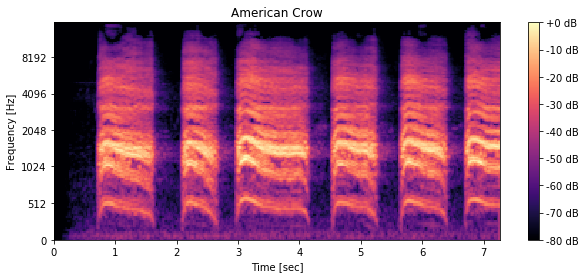

In [22]:
# Insert crow call image

%matplotlib inline
# Import python packages
from matplotlib import pyplot as plt # for plotting
from scipy.io import wavfile  # for reading WAV files
import librosa.display  # For creating the Mel spectrogram

# 1. Read WAV file
sampling_rate, samples = wavfile.read(str(Path(config["work_dir"]).joinpath("amecrow.wav").absolute()))
# 2. Normalize audio to lie between +1.0 and -1.0
samples = samples / np.max(np.abs(samples))
# 3. Create figure with given size
plt.figure(figsize=(10, 4))
# 4. Create Mel Spectrogram
spec = librosa.feature.melspectrogram(y=samples, sr=sampling_rate, n_mels=128, fmax=sampling_rate // 2)
# 5. Plot Mel spectrogram in figure
librosa.display.specshow(librosa.power_to_db(spec, ref=np.max), y_axis = 'mel', fmax = sampling_rate // 2, x_axis = 'time')
# 6. Create color gradient legend on the side of the plot (in decibel)
plt.colorbar(format='%+2.0f dB')
# 7. Set plot title
plt.title('American Crow')
# 8. Set y axis label
plt.ylabel('Frequency [Hz]')
# 9. Set x axis label
plt.xlabel('Time [sec]')
# 10. Finally, show the figure
plt.show()

In [47]:
#==========================================================================================
# Load and decode audio and create spectrogram
#==========================================================================================
file_path = [
    str(Path(config["work_dir"]).joinpath("amecrow.wav").absolute())
]
target = ["amecrow"]
test_dataset = tf.data.Dataset.from_tensor_slices((file_path, target))

test_dataset = test_dataset.map(load_audio, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.map(audio_to_fft, num_parallel_calls=tf.data.experimental.AUTOTUNE)

#==========================================================================================
# Prepare batches and prefetch for datasets
#==========================================================================================
test_dataset = test_dataset.batch(config["batch_size"])
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [48]:
#==========================================================================================
# Get predictions for test items
#==========================================================================================
result = model.predict(test_dataset)

In [81]:
#==========================================================================================
# Get the class names of the 5 predicted classes with the highest probabilities
#==========================================================================================
# This line first sorts the result by probabilities, but returns the sorted indices (argsort).
# Then, it reverses them ([::-1]) and takes the first 5 ([0:5]).
# Finally, it queries the class names associated with the indices.
top5_class_indices = np.argsort(result)[0][::-1][0:5]
encoder.classes_[top5_class_indices]

array(['amecro', 'eawpew', 'coohaw', 'reshaw', 'brdowl'], dtype='<U7')

In [85]:
#==========================================================================================
# Get the 5 highest probabilities of the predicted classes
#==========================================================================================
# This line first sorts the result by probabilities.
# Then, it reverses them ([::-1]) and takes the first 5 ([0:5]).
top5_probabilities = np.sort(result)[0][::-1][0:5]
top5_probabilities

array([1.0000000e+00, 4.8617178e-12, 3.3998444e-12, 5.3872180e-14,
       4.6712210e-14], dtype=float32)

The top probability is 1.00 and the rest are very low, so it seems like the model is very sure that the audio call belongs in fact to an American Crow. Another way of confirming this is by assigning a probability threshold over which the model considers the targets to be "true"

In [83]:
#==========================================================================================
# Get lists of ebird codes for each test item that have a higher score than 'threshold'
#==========================================================================================

threshold = 0.5
# Get outputs for current test file
current_outputs = result[0]
# Determine which of the outputs are over the threshold
detected_targets = np.argwhere(current_outputs > threshold)
if len(detected_targets) > 0:
    # Get ebird_code names from detected targets
    detected_ebird_codes = encoder.inverse_transform(detected_targets[0])
    # Concatenate all detected ebird_codes to a string, with " " (space) between them
    detected_ebird_codes = " ".join(detected_ebird_codes)
else:
    detected_ebird_codes = "nocall"

detected_ebird_codes

'amecro'

This confirms that the only bird class above the assigned probability of 0.5 is the American crow. 